In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print(train_df.head())

   id         region  year manufacturer  condition    cylinders fuel  \
0   0      nashville  1949          bmw  excellent  6 cylinders  gas   
1   1  state college  2013       toyota       fair  8 cylinders  gas   
2   2        wichita  1998         ford       good  6 cylinders  gas   
3   3         albany  2014         ford  excellent  4 cylinders  gas   
4   4        redding  2005         ford  excellent  6 cylinders  gas   

   odometer title_status transmission drive       size         type  \
0    115148        clean       manual   rwd   mid-size  convertible   
1    172038        clean    automatic   rwd  full-size        sedan   
2    152492        clean    automatic   fwd  full-size          SUV   
3    104118        clean       manual   fwd   mid-size          SUV   
4    144554        clean       manual   fwd   mid-size        sedan   

  paint_color state  price  
0      orange   NaN  27587  
1      silver    pa   4724  
2      silver    ks  10931  
3        blue    ny  165

In [3]:
# Label encoding
le = preprocessing.LabelEncoder()
categorical_column = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
for col in categorical_column:
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.fit_transform(test_df[col].astype(str))

In [4]:
# data splitting
target = train_df['price']
train_df_ = train_df.drop(['id', 'price'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(train_df_, target, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(20649, 14) (6883, 14) (20649,) (6883,)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 20649, number of used features: 14
[LightGBM] [Info] Start training from score 5295.000000
45.71162186656015


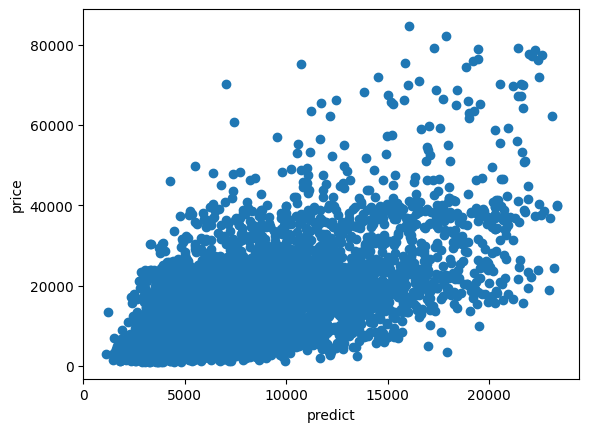

,importance
odometer,574
year,466
region,377
manufacturer,357
state,232
condition,212
type,169
paint_color,160
drive,110
cylinders,109


In [5]:
# learning
train_set = lgbm.Dataset(X_train, y_train)
valid_set = lgbm.Dataset(X_valid, y_valid)
params = {'objective': 'mape',
          'metric': 'mape',
          }
model = lgbm.train(params = params, 
                   train_set = train_set,
                   valid_sets = [train_set, valid_set])

pred = model.predict(X_valid)
score = mean_absolute_percentage_error(y_valid, pred)
print(score*100)
plt.scatter(pred, y_valid)
plt.xlabel('predict')
plt.ylabel('price')
plt.show()

importance = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=['importance'])
display(importance.sort_values('importance', ascending=False))

In [49]:
# submit
predict = model.predict(test_df)
submit = pd.read_csv("data/submit_sample.csv", header=None)
submit[1] = predict
submit.to_csv("submission.csv", index=False, header=None)